# Importar bibliotecas básicas

In [128]:
# !pip install scikit-learn
# !pip install sklearn.preprocessing
# !pip install cython
# !pip install --upgrade pip
# !pip install seaborn
# !pip install plotly
# !pip install --upgrade numpy

In [129]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Importar dados

In [130]:

paths = ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv','Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
            'Friday-WorkingHours-Morning.pcap_ISCX.csv','Monday-WorkingHours.pcap_ISCX.csv',
            'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv','Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
            'Tuesday-WorkingHours.pcap_ISCX.csv','Wednesday-workingHours.pcap_ISCX.csv']
dfs = []
data_folder = '/home/andre/unicamp/IC/machine_learning/reinforcement_learning/tabular_data/data/raw_data'
for path in paths:
    dfs.append(pd.read_csv(os.path.join(data_folder,path), encoding='utf-8'))
df = pd.concat(dfs)

In [131]:
df.sample()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
124580,443,63807500,7,2,176,82,45,6,25.142857,18.397722,...,20,16914.0,0.0,16914,16914,59000000.0,0.0,59000000,59000000,BENIGN


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

# Tratamento de dados

In [133]:
df = df.sample(2830743)
df.reset_index(drop=True, inplace=True)


In [134]:
#eliminate spaces in column names
df.columns = [col.strip() for col in df.columns]

In [135]:
df['Label'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2830743 entries, 0 to 2830742
Series name: Label
Non-Null Count    Dtype 
--------------    ----- 
2830743 non-null  object
dtypes: object(1)
memory usage: 21.6+ MB


In [136]:
# Replace inf and -inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827876 entries, 0 to 2827875
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

## Balancear base de dados

### Filtrar classes muito pequenas

In [138]:
# remove classes with less than 5000 instances
df_balanced = df.groupby('Label').filter(lambda x : len(x)>=5000)

In [139]:
df_balanced.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,31186,2,2,66,122,33,33,33.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,80,752100,3,5,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS
2,53,48737,2,2,62,228,31,31,31.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,443,160977,10,5,1092,639,837,0,109.200000,260.516069,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,53,30491,1,1,46,90,46,46,46.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Separar base de ataques surpresa

In [140]:
surprise_attacks = df.groupby('Label').filter(lambda x : len(x)<5000)
surprise_attacks['Label'] = surprise_attacks['Label'].apply(lambda x: 'Attack' if x != 'BENIGN' else 'BENIGN')
surprise_attacks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4183 entries, 1274 to 2826805
Data columns (total 79 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Destination Port             4183 non-null   int64  
 1   Flow Duration                4183 non-null   int64  
 2   Total Fwd Packets            4183 non-null   int64  
 3   Total Backward Packets       4183 non-null   int64  
 4   Total Length of Fwd Packets  4183 non-null   int64  
 5   Total Length of Bwd Packets  4183 non-null   int64  
 6   Fwd Packet Length Max        4183 non-null   int64  
 7   Fwd Packet Length Min        4183 non-null   int64  
 8   Fwd Packet Length Mean       4183 non-null   float64
 9   Fwd Packet Length Std        4183 non-null   float64
 10  Bwd Packet Length Max        4183 non-null   int64  
 11  Bwd Packet Length Min        4183 non-null   int64  
 12  Bwd Packet Length Mean       4183 non-null   float64
 13  Bwd Packet Length

In [141]:
surprise_attacks.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1274,53884,40,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Attack
2133,8080,1029382,3,3,0,18,0,0,0.0,0.0,...,28,0.0,0.0,0,0,0.0,0.0,0,0,Attack
3821,8080,12,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Attack
3947,80,5197400,3,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Attack
4140,8080,997270,3,3,0,18,0,0,0.0,0.0,...,28,0.0,0.0,0,0,0.0,0.0,0,0,Attack


In [142]:
surprise_attacks['Label'].apply(lambda x: 1 if x == 'Attack' else 0).value_counts()

Label
1    4183
Name: count, dtype: int64

In [143]:
surprise_attacks.reset_index(drop=True, inplace=True)

In [144]:
surprise_attacks['Label'].value_counts()

Label
Attack    4183
Name: count, dtype: int64

In [145]:
surprise_attacks.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53884,40,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Attack
1,8080,1029382,3,3,0,18,0,0,0.0,0.0,...,28,0.0,0.0,0,0,0.0,0.0,0,0,Attack
2,8080,12,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Attack
3,80,5197400,3,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Attack
4,8080,997270,3,3,0,18,0,0,0.0,0.0,...,28,0.0,0.0,0,0,0.0,0.0,0,0,Attack


### Separar bases de um ataque

In [146]:
one_attack = df_balanced.copy()
one_attack['Label'] = one_attack['Label'].apply(lambda x: 'Attack' if x != 'BENIGN' else 'BENIGN')

In [147]:
one_attack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2823693 entries, 0 to 2827875
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow 

### Undersample majority classes

In [148]:
df['Label'].value_counts()

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

#### Multiple attacks

In [149]:
from imblearn.under_sampling import NearMiss

X_mul = df_balanced.drop('Label', axis=1)
y_mul = df_balanced['Label']

# encode labels
le_mul = LabelEncoder()
y_mul = le_mul.fit_transform(y_mul)


In [150]:
le_mul.classes_

array(['BENIGN', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
       'DoS slowloris', 'FTP-Patator', 'PortScan', 'SSH-Patator'],
      dtype=object)

In [151]:
# define the number of samples to keep for each class
sampling_strategy = {0: 10000, 1: 10000, 2: 10000, 3:10000, 4:len(y_mul[y_mul==4]), 5:len(y_mul[y_mul==5]), 6:len(y_mul[y_mul==6]), 7: 10000, 8:len(y_mul[y_mul==8])}  # Keep 5000 samples of Benign class

# Apply NearMiss to the majority classes
nm = NearMiss(sampling_strategy=sampling_strategy)
X_res_mul, y_res_mul = nm.fit_resample(X_mul, y_mul)

#### One attack

In [152]:
one_attack.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,31186,2,2,66,122,33,33,33.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,80,752100,3,5,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Attack
2,53,48737,2,2,62,228,31,31,31.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,443,160977,10,5,1092,639,837,0,109.200000,260.516069,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,53,30491,1,1,46,90,46,46,46.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,53,171,2,2,102,134,51,51,51.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,53,175,2,2,86,162,43,43,43.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,55311,91,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,53,180,2,2,68,158,34,34,34.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,80,47360,3,4,438,860,438,0,146.000000,252.879418,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [153]:
X_one = one_attack.drop('Label', axis=1)
y_one = one_attack['Label']

# encode labels
le_one = LabelEncoder()
le_one.classes_ = np.array(['BENIGN', 'Attack'])
y_one = le_one.transform(y_one)


In [154]:
# le_one.classes_
for i in range(10):
    print(y_one[i])

0
1
0
0
0
0
0
0
0
0


In [155]:
from imblearn.under_sampling import RandomUnderSampler
# acredito nao fazer sentido usar o NearMiss para o one attack, pois os ataques são variados e não será possível encontrar uma forma de reduzir a quantidade de ataques por estratégias de vizinho mais próximo
# define the number of samples to keep for each class
sampling_strategy = {0: 45000, 1: 45000}
# Apply UnderSample to the majority classes
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res_one, y_res_one = rus.fit_resample(X_one, y_one)

### Oversample minority classes

In [156]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_res_mul, y_res_mul = smote.fit_resample(X_res_mul, y_res_mul)

#### Convert data back into dataframes

In [157]:
# Convert resampled data back to DataFrame
X_res_mul = pd.DataFrame(X_res_mul, columns=X_mul.columns)
y_res_mul = pd.Series(y_res_mul)

# Decode labels
# y_res_mul = pd.Series(le_mul.inverse_transform(y_res_mul))


# Reset indices
X_res_mul.reset_index(drop=True, inplace=True)
y_res_mul.reset_index(drop=True, inplace=True)


# Combine resampled features and labels
multiple_attacks = pd.concat([X_res_mul, y_res_mul.rename('Label')], axis=1)

# Display the first few rows of the new DataFrame
multiple_attacks.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,63123466,7,0,0,0,0,0,0.0,0.0,...,40,7011966.0,0.0,7011966,7011966,18700000.0,12200000.0,32100000,8015933,0
1,80,63100251,7,0,0,0,0,0,0.0,0.0,...,40,7004721.0,0.0,7004721,7004721,18700000.0,12200000.0,32100000,8015932,0
2,80,63124098,7,0,0,0,0,0,0.0,0.0,...,40,7012598.0,0.0,7012598,7012598,18700000.0,12200000.0,32100000,8015932,0
3,80,63103844,7,0,0,0,0,0,0.0,0.0,...,40,7008302.0,0.0,7008302,7008302,18700000.0,12200000.0,32100000,8015928,0
4,80,63101726,7,0,0,0,0,0,0.0,0.0,...,40,7006190.0,0.0,7006190,7006190,18700000.0,12200000.0,32100000,8015934,0


In [158]:
# Convert resampled data back to DataFrame
X_res_one = pd.DataFrame(X_res_one, columns=X_one.columns)
y_res_one = pd.Series(y_res_one)

# Decode labels
# y_res_one = pd.Series(le_one.inverse_transform(y_res_one))

# Reset indices
X_res_one.reset_index(drop=True, inplace=True)
y_res_one.reset_index(drop=True, inplace=True)

# Combine resampled features and labels
one_attack = pd.concat([X_res_one, y_res_one.rename('Label')], axis=1)

# Display the first few rows of the new DataFrame
one_attack.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,13598362,5,5,2889,900,2889,0,577.800000,1292.000077,...,32,3595715.0,0.0,3595715,3595715,9997703.0,0.0,9997703,9997703,0
1,443,5710360,6,5,364,189,224,0,60.666667,85.556219,...,20,247283.0,0.0,247283,247283,5463074.0,0.0,5463074,5463074,0
2,443,904809,7,6,878,3630,533,0,125.428571,195.936943,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,53,47986,1,1,39,121,39,39,39.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
4,80,439,3,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0


In [159]:
print(multiple_attacks['Label'].value_counts(),one_attack['Label'].value_counts())

Label
0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
6    10000
7    10000
8    10000
Name: count, dtype: int64 Label
0    45000
1    45000
Name: count, dtype: int64


In [160]:
multiple_attacks = multiple_attacks.sample(90000)
multiple_attacks.reset_index(drop=True, inplace=True)
multiple_attacks.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6692,79,1,1,0,6,0,0,0.0000,0.000000,...,40,0.000000e+00,0.000000e+00,0,0,0.0,0.0,0,0,7
1,8042,96,1,1,0,6,0,0,0.0000,0.000000,...,40,0.000000e+00,0.000000e+00,0,0,0.0,0.0,0,0,7
2,80,63137610,7,0,0,0,0,0,0.0000,0.000000,...,40,7.010132e+06,0.000000e+00,7010132,7010132,18700000.0,12200000.0,32100000,8015897,4
3,80,63134034,7,0,0,0,0,0,0.0000,0.000000,...,40,7.006459e+06,0.000000e+00,7006459,7006459,18700000.0,12200000.0,32100000,8015924,4
4,80,105682421,16,3,2541,6,231,0,158.8125,110.582831,...,32,4.705994e+06,6.654526e+06,9411454,534,19300000.0,18800000.0,51300000,5745400,5


In [161]:
one_attack = one_attack.sample(90000)
one_attack.reset_index(drop=True, inplace=True)
one_attack.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,30420,1,1,50,78,50,50,50.00,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,1145,43,1,1,2,6,2,2,2.00,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,1
2,49666,24,1,3,6,18,6,6,6.00,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,80,99946846,8,6,1038,11595,346,0,129.75,179.072013,...,32,2024.0,0.0,2024,2024,99400000.0,0.0,99400000,99400000,1
4,6547,45,1,1,0,6,0,0,0.00,0.000000,...,40,0.0,0.0,0,0,0.0,0.0,0,0,1


# Divisão entre previsores e classe

In [162]:
print(one_attack['Label'].value_counts(), multiple_attacks['Label'].value_counts())

Label
0    45000
1    45000
Name: count, dtype: int64 Label
7    10000
4    10000
5    10000
8    10000
1    10000
2    10000
3    10000
6    10000
0    10000
Name: count, dtype: int64


In [163]:
from sklearn.model_selection import train_test_split
x_one_train, x_one_test, y_one_train, y_one_test = train_test_split(one_attack.drop('Label', axis=1), one_attack['Label'], test_size=0.2, 
                                                                    random_state=42, shuffle=True, stratify=one_attack['Label'])

x_mul_train, x_mul_test, y_mul_train, y_mul_test = train_test_split(multiple_attacks.drop('Label', axis=1), multiple_attacks['Label'], test_size=0.2,
                                                                    random_state=42, shuffle=True, stratify=multiple_attacks['Label'])
x_sur_test = surprise_attacks.drop('Label', axis=1)
y_sur_test = surprise_attacks['Label']

In [164]:
# #check what are the categories in the column ' Label' and how many instances are there for each category
# x_one_train.info()
# x_one_test.info()
# y_one_train.info()
# y_one_test.info()
# x_mul_train.info()
# x_mul_test.info()
# y_mul_train.info()
# y_mul_test.info()
y_sur_test.info()



<class 'pandas.core.series.Series'>
RangeIndex: 4183 entries, 0 to 4182
Series name: Label
Non-Null Count  Dtype 
--------------  ----- 
4183 non-null   object
dtypes: object(1)
memory usage: 32.8+ KB


In [165]:
for dataset in [x_one_train, x_one_test, y_one_train, y_one_test, x_mul_train, x_mul_test, y_mul_train, y_mul_test]:
    print(dataset.shape)

(72000, 78)
(18000, 78)
(72000,)
(18000,)
(72000, 78)
(18000, 78)
(72000,)
(18000,)


In [166]:
for dataset in [x_one_train, x_one_test, y_one_train, y_one_test, x_mul_train, x_mul_test, y_mul_train, y_mul_test]:
    print(dataset.isnull().sum())


Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 78, dtype: int64
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 78, dtype: int64
0
0
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min            

# Normalização

In [167]:
from sklearn.preprocessing import MinMaxScaler


minmax_scaler        = MinMaxScaler()
x_norm               = minmax_scaler.fit_transform(x_one_train)
x_one_train          = pd.DataFrame(x_norm)
x_norm               = minmax_scaler.fit_transform(x_one_test)
x_one_test           = pd.DataFrame(x_norm)
x_norm               = minmax_scaler.fit_transform(x_mul_train)
x_mul_train          = pd.DataFrame(x_norm)
x_norm               = minmax_scaler.fit_transform(x_mul_test)
x_mul_test           = pd.DataFrame(x_norm)
x_norm               = minmax_scaler.fit_transform(x_sur_test)
x_sur_test           = pd.DataFrame(x_norm)


# PCA - redução de dimensões

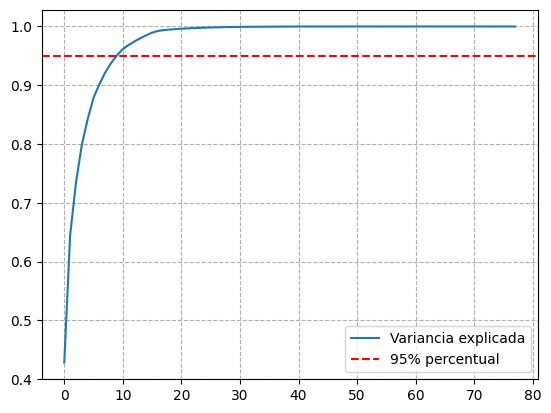

In [168]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA().fit(x_one_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Variancia explicada')
plt.axhline(0.95,color='red',linestyle='--',label='95% percentual')
plt.grid(True, linestyle='--')
plt.legend()

In [169]:
to_pca = [x_one_train, x_one_test, x_mul_train, x_mul_test, x_sur_test]
to_df = []
for df in to_pca:
    pca       = PCA(n_components=15)
    dados_pca = pca.fit_transform(df)
    to_df.append(pd.DataFrame(dados_pca))
    # df.head()
    # sns.scatterplot(x=dados_pca[:,0],y=dados_pca[:,1],hue=Y)
to_df.append(y_one_train)
to_df.append(y_one_test)
to_df.append(y_mul_train)
to_df.append(y_mul_test)
to_df.append(y_sur_test)


# Ajustar formatos

In [170]:
to_float32 = []
for df in to_df:
    to_float32.append(pd.DataFrame(df))


In [171]:
# Convert only float64 columns to float32
to_save = []
for df in to_float32:
    to_save.append(df.apply(lambda x: x.astype('float32') if x.dtype == 'float64' or x.dtype == 'int64' else x))


# Salvar bases de dados

In [172]:
## aqui não vale a pena dropar as linhas duplicadas, pois droparíamos as duplicadas no x e perderíamos a referência do y
# data = data.drop_duplicates()

In [173]:
name = ['x_one_train.csv','x_one_test.csv','x_mul_train.csv','x_mul_test.csv','x_sur_test','y_one_train.csv','y_one_test.csv','y_mul_train.csv','y_mul_test.csv', 'y_sur_test.csv']
for df,i in zip(to_save,range(len(to_save))):
    df.to_csv(name[i], index=False)

In [174]:
to_save[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.924503,-0.204735,0.576371,-0.012158,-0.280698,-0.010892,0.231804,-0.281719,-0.128225,0.184051,-0.324340,0.927377,0.083392,-0.004332,0.062579
1,-0.686781,0.367738,0.042845,0.420165,0.339370,-0.185305,-0.529179,-0.063189,-0.606044,0.107539,0.010015,0.032728,-0.022731,-0.054872,-0.103808
2,-0.309278,-0.792993,0.092245,-0.024246,-0.171170,0.063253,0.257141,0.348995,-0.135543,-0.077505,0.094763,-0.019883,-0.046955,-0.309181,0.543967
3,-0.328868,-0.835941,0.144329,0.124723,0.117214,-0.073299,-0.002047,0.204650,-0.340179,0.208185,0.107420,-0.008284,-0.015809,-0.062848,0.000288
4,-0.124145,-0.740460,0.052067,0.012435,-0.219348,-0.002899,0.173908,0.195808,-0.030063,-0.077892,0.045128,-0.007710,0.031009,0.064394,-0.098466
